# A 1D Theory

## Introduction

In the previous two notebooks, we introduced the Metropolis algorithm as a way to sample a Gaussian distribution, which could be regarded as the distribution of a field at a single point in spacetime (0-dimensional).

Now, we consider a scalar field in one dimension, $\phi = \phi(x)$, with space discretized to a lattice of only two spacetime points, $x_{1}$ and $x_{2}$. \
The discretized action is given by
\begin{equation}
    S[\phi(x)] = \phi^{2}_{1} + \phi^{2}_{2} + \phi^{2}_{1} \phi^{2}_{2}, \qquad \phi_{i} := \phi(x_{i}).
\end{equation}
It is important to notice that without the term $\phi^{2}_{1} \phi^{2}_{2}$ the distribution would just be a product of two Gaussian distributions, for which $\phi_{1}$ and $\phi_{2}$ would be independent of each other.\
Hence, the last term couples $\phi_{1}$ to $\phi_{2}$, which can be seen as a _self-interaction of the field_ between these two points.

In this case, the configurations in our Markov chain will be pairs of values $(\phi_{1}, \phi_{2})$, i.e., a single configuration requires specifying the field _at all points in the lattice_.

As before, we estimate expectation values via the sample mean
\begin{equation}
    \langle O[\phi] \rangle = \frac{1}{N} \sum_{k = 1}^{N} O[\phi_{k}],
\end{equation}
where $\phi_{k} = (\phi_{1}, \phi_{2})_{k}$ denotes the $k$-th sample of the chain.

Also, the “naive” estimate of the statistical error
\begin{equation}
    \sigma = \frac{\sigma_{O}}{\sqrt{N - 1}} = \sqrt{\frac{\langle O^{2} - \langle O \rangle^{2}}{N - 1}}.
\end{equation}

Here, we will be interested in observables of the form $O[\phi] = \phi_{1}^{m} \phi_{2}^{n}$.

## Setup

In order to get used to NumPy, here we will work with numpy arrays.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


def compute_action(phi: np.ndarray) -> np.ndarray:
    return (phi[0] ** 2) + (phi[1] ** 2) + (phi[0] * phi[1]) ** 2


def propose_phi(phi: np.ndarray,
                width: float,
                rng: np.random.Generator) -> np.ndarray:
    delta = 2 * rng.random(size=2) - 1  # Two random numbers between -1 and 1.
    return phi + width * delta


def metropolis_step(phi: np.ndarray,
                    width: float,
                    rng: np.random.Generator) -> tuple[np.ndarray, int]:
    # 1. Proposal
    proposed_phi = propose_phi(phi, width, rng)

    # 2. Acceptance probability.
    current_action = compute_action(phi)
    proposed_action = compute_action(proposed_phi)
    p_acceptance = np.min([1.0, np.exp(current_action - proposed_action)])

    # 3. Accept/reject
    r = rng.random()

    if r <= p_acceptance:  # Accept.
        return proposed_phi, 1

    # Reject.
    return phi, 0


def sample_field(initial_phi: np.ndarray,
                 num_samples: int,
                 width: float | np.ndarray,
                 rng: np.random.Generator) -> tuple[np.ndarray, list[int]]:
    chain = [initial_phi]
    acceptance = []

    for idx in range(num_samples):
        phi, accepted = metropolis_step(phi=chain[-1], width=width, rng=rng)
        chain.append(phi)
        acceptance.append(accepted)

    chain = np.array(chain)

    return chain, acceptance

## 1. Generate a Markov chain

1. Choose a starting configuration $\phi = (\phi_{1}, \phi_{2})$.
2. Find a width that gives an acceptance rate anywhere between 70 to 80%. \
You can do this in any way you see fit. \
One example would be to generate chains with a few samples (~1,000), and then adjusting the width manually.
3. Once you have a width in this range, generate a large number of samples (>55,500).

In [2]:
my_initial_phi = np.array([5.0, 5.0])
n_therm = 20
sample_size = 166320 + n_therm - 1
phi_chain, acceptances = sample_field(initial_phi=my_initial_phi,
                                      num_samples=sample_size,
                                      width=12,
                                      rng=np.random.default_rng(seed=42))
print(f"Acceptance rate: {np.mean(acceptances) * 100:.2f}")

Acceptance rate: 0.82


### Visualizing the distribution

Once you have generated a large number of samples, you can compare the distribution density of your chain against the exact density $P(\phi) = \mathrm{e}^{-S[\phi]} / Z$ by running the two cells below.

In [3]:
def plot_distributions(phi1_vals: np.ndarray, phi2_vals: np.ndarray, bins: int = 40):
    d_fig, d_axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)
    im = d_axes[0].hist2d(x=phi1_vals, y=phi2_vals, bins=bins, density=True)[3]
    d_axes[0].set_title("Histogram of samples", fontsize=14)
    d_axes[0].set_aspect('equal', 'box')
    d_axes[0].set_xlabel(r"$\phi_{1}$", fontsize=13)
    d_axes[0].set_ylabel(r"$\phi_{2}$", fontsize=13, rotation=0)
    d_fig.colorbar(im).set_label(label=r"$Q[\phi]$", fontsize=13, rotation=0, labelpad=15)
    d_axes[0]: plt.Axes

    # True distribution...
    x_min, x_max = d_axes[0].get_xlim()
    y_min, y_max = d_axes[0].get_ylim()
    phi_x1, phi_x2 = np.meshgrid(np.linspace(x_min, x_max, 101),
                                 np.linspace(y_min, y_max, 101))
    norm = np.sqrt(np.e * np.pi) * 0.92441907
    true_dist = np.exp(-((phi_x1 ** 2) + (phi_x2 ** 2) + (phi_x1 * phi_x2) ** 2)) / norm
    QCS = d_axes[1].contourf(phi_x1, phi_x2, true_dist)
    d_axes[1].set_title("True distribution", fontsize=14)
    d_axes[1].set_aspect('equal', 'box')
    d_axes[1].set_xlabel(r"$\phi_{1}$", fontsize=13)
    d_axes[1].set_ylabel(r"$\phi_{2}$", fontsize=13, rotation=0)
    d_fig.colorbar(QCS).set_label(label=r"$P[\phi]$", fontsize=13, rotation=0, labelpad=15)

    return d_fig, d_axes

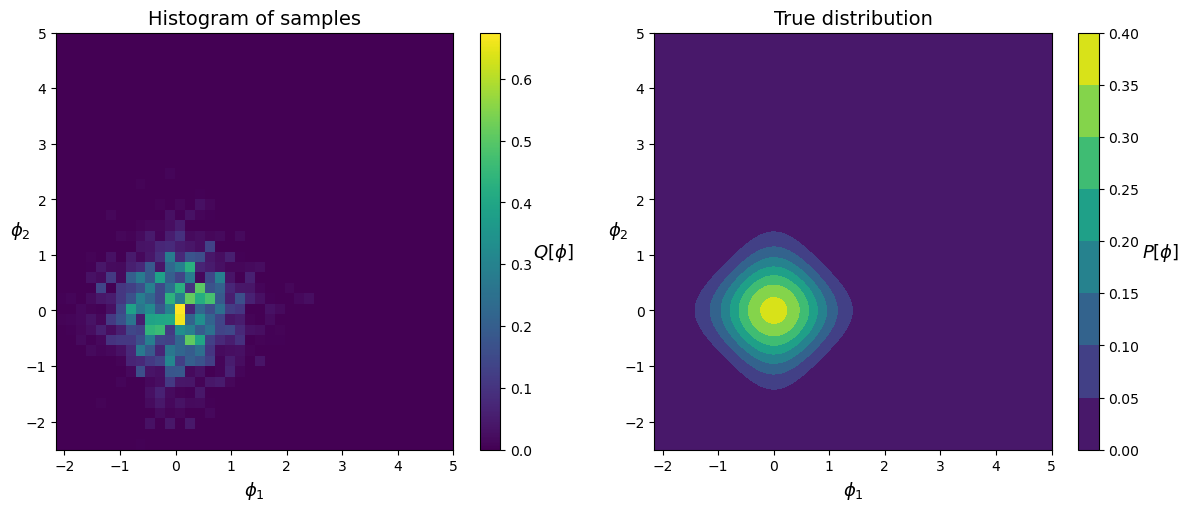

In [4]:
phi1, phi2 = phi_chain.T
plot_distributions(phi1_vals=phi1.flatten(), phi2_vals=phi2.flatten())
plt.show()

## 2. Check for thermalization

We need to verify that our Markov chain has thermalized. \
This is done by looking at the values of observables, just as we did last time, where our observable was simply the value of the field itself. \
Here, we look at two observables: $\phi_{1}$ and $\phi_{1}^{2} \phi_{2}^{2}$.

1. Run the cell below, which defines a function to plot observables.
2. Then, in the cell following that one, choose a value for $N_{\text{therm}}$ where both observables have thermalized, by trying different values for $N_{\text{therm}}$.

In [5]:
def plot_observable(obs_values: np.ndarray, n_thermal: int):
    o_fig, o_axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)
    o_axes[0].plot(obs_values)
    o_axes[0].set_xlabel("Monte Carlo step", fontsize=12)
    o_axes[0].set_title("Before thermalization", fontsize=14)

    o_axes[1].plot(obs_values[n_thermal:])
    o_axes[1].set_xlabel("Monte Carlo step", fontsize=12)
    o_axes[1].set_title("After thermalization", fontsize=14)

    return o_fig, o_axes

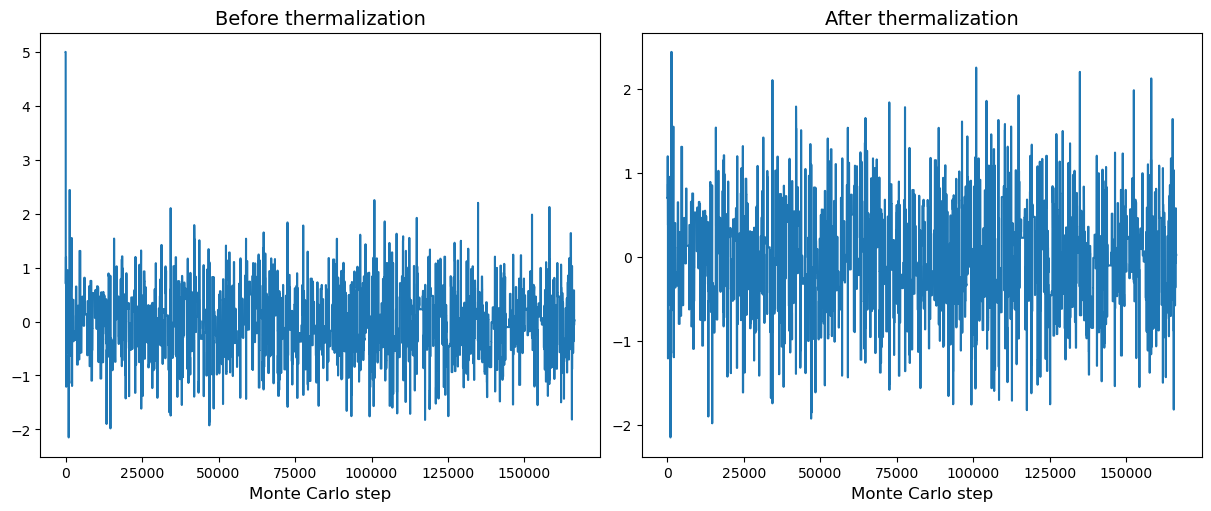

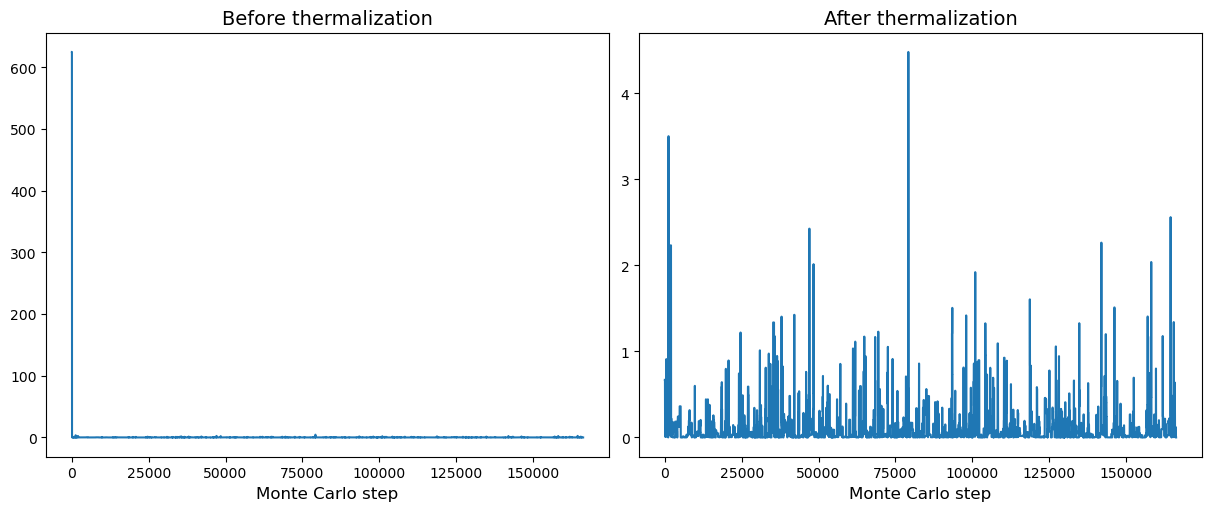

In [6]:
plot_observable(phi1, n_thermal=n_therm)
plot_observable((phi1 ** 2) * (phi2 ** 2), n_thermal=n_therm)
plt.show()

After choosing a suitable amount of samples for thermalization, we define thermalized series for $\phi_{1}$ and $\phi_{2}$.

In [7]:
phi1_t = phi1[n_therm:]
phi2_t = phi2[n_therm:]

Additionally, you can also see the distribution density for your thermalized samples.

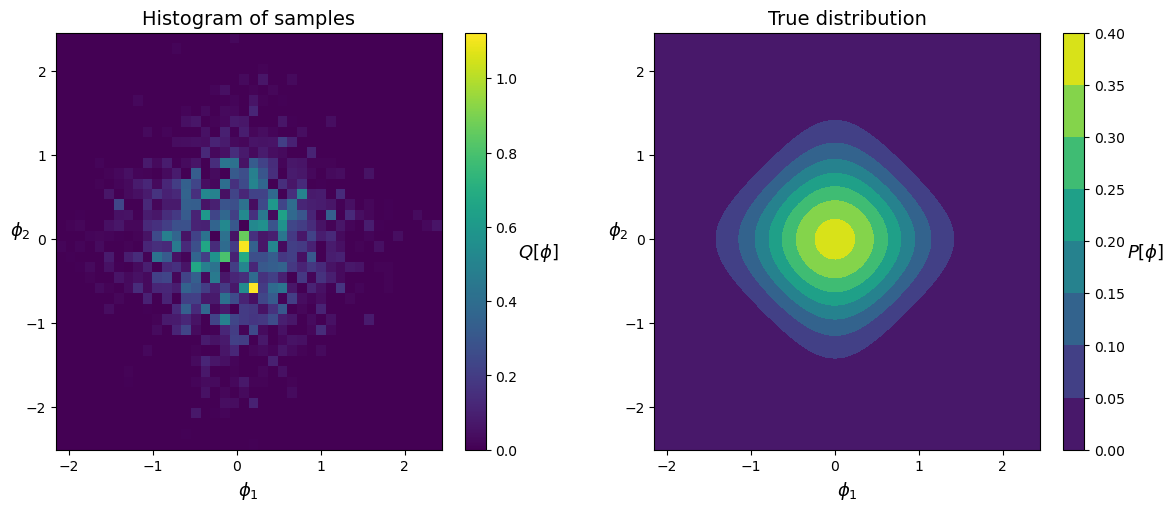

In [8]:
plot_distributions(phi1_vals=phi1_t, phi2_vals=phi2_t, bins=40)
plt.show()

## 3. Measurements

Write a function that computes the sample mean and the “naive” estimated error for observables of the form $O[\phi] = \phi_{1}^{m} \phi_{2}^{n}$.

To verify your implementation, here are some analytical results:

| $(m, n)$ | Exact value |
|:---------|------------:|
| (2, 2)   | 0.104064... |
| (2, 4)   | 0.093904... |
| (2, 6)   | 0.156096... |
| (4, 4)   | 0.062191... |

Additionally:
* If either $m$ or $n$ is odd (or both), the exact value is zero.
* The values for $(m, n)$ and $(n, m)$ are equal.

In [9]:
# TODO: Here goes your function.

def sample_mean_and_naive_error(phi: np.array, m: int, n: int) -> tuple[float, float]:
    N = len(phi[0])
    observable = phi[0]**m*phi[1]**n

    sample_mean = 1/N*np.sum(observable)

    sigma_O = np.std(observable)
    naive_error = 1/np.sqrt(N - 1)*sigma_O
    
    return sample_mean, naive_error 

values = [[2,2], [2,4], [2,6], [4,4]]
exact_values = [0.104064, 0.093904, 0.156096, 0.062191]

phi1_t = phi1[n_therm:]
phi2_t = phi2[n_therm:]
phi = [phi1_t, phi2_t]

sample_means = []
naive_errors = []

for i, val in enumerate(values): 
    m = val[0]
    n = val[1]
    sample_mean, naive_error = sample_mean_and_naive_error(phi, m, n)
    sample_means.append(sample_mean)
    naive_errors.append(naive_error)

sigmas = [np.abs(sample_means[i] - exact_values[i]) / naive_errors[i] for i in range(len(values))]
header = "n / m \t|\tExact\t|\t\tNaive Estimate\t\t|\tSigmas from exact value"
print(header)
print("-" * (len(header) + 40))
[print(f"{val}\t|\t{exact_values[idx]:4g}\t|\t{sample_means[idx]:7.4f} +/- {naive_errors[idx]:.4f}\t|\t\t\t{sigmas[idx]:.1f}")  for idx, val in enumerate(values)]


n / m 	|	Exact	|		Naive Estimate		|	Sigmas from exact value
---------------------------------------------------------------------------------------------------
[2, 2]	|	0.104064	|	 0.0996 +/- 0.0006	|			7.6
[2, 4]	|	0.093904	|	 0.0953 +/- 0.0012	|			1.2
[2, 6]	|	0.156096	|	 0.1787 +/- 0.0041	|			5.5
[4, 4]	|	0.062191	|	 0.0656 +/- 0.0012	|			2.9


[None, None, None, None]

### Binning method

Finally, apply the binning method to the observable $\phi_{1}^{2} \phi_{2}^{2}$ to obtain a better error estimate.

For this:
1. Run the cell below to obtain the bin sizes which are divisors to the number of thermalized samples. \
If you see only a few bin sizes, less than 50 for example, you can try to generate a sample size such that you end up with exactly 55,440 thermalized samples.
2. For each of these bin sizes, obtain the errors on the binned chain, just as in the previous notebook. \
Remember to avoid bin sizes that result in only a few samples (e.g. < 200), as their errors will not be reliable.
3. Plot the error estimate as a function of the bin size.
    * Can you identify a plateau?
    * What is the resulting error estimate?
    * How many sigmas (i.e. error estimates) is your result away from the exact value?

In [10]:
sample_size = len(phi1_t)
max_search = int(np.sqrt(sample_size)) + 2
bin_sizes = []
for i in range(1, max_search):
    if sample_size % i == 0:
        bin_sizes.append(i)
        bin_sizes.append(sample_size // i)
bin_sizes.sort()
print(bin_sizes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 27, 28, 30, 33, 35, 36, 40, 42, 44, 45, 48, 54, 55, 56, 60, 63, 66, 70, 72, 77, 80, 84, 88, 90, 99, 105, 108, 110, 112, 120, 126, 132, 135, 140, 144, 154, 165, 168, 176, 180, 189, 198, 210, 216, 220, 231, 240, 252, 264, 270, 280, 297, 308, 315, 330, 336, 360, 378, 385, 396, 420, 432, 440, 462, 495, 504, 528, 540, 560, 594, 616, 630, 660, 693, 720, 756, 770, 792, 840, 880, 924, 945, 990, 1008, 1080, 1155, 1188, 1232, 1260, 1320, 1386, 1485, 1512, 1540, 1584, 1680, 1848, 1890, 1980, 2079, 2160, 2310, 2376, 2520, 2640, 2772, 2970, 3024, 3080, 3465, 3696, 3780, 3960, 4158, 4620, 4752, 5040, 5544, 5940, 6160, 6930, 7560, 7920, 8316, 9240, 10395, 11088, 11880, 13860, 15120, 16632, 18480, 20790, 23760, 27720, 33264, 41580, 55440, 83160, 166320]


In [11]:
# TODO: Here you can obtained the binned errors.
m = 2
n = 2
measurements = (phi[0]**m)*(phi[1]**n)
measurements = np.array(measurements)
binned_errors = []
for i, size in enumerate(bin_sizes):
    Markov_chain = len(measurements) // size
    if Markov_chain < 200: 
        bin_sizes = bin_sizes[:i]
        break
    binned_obs = measurements.reshape(Markov_chain, size)
    binned_obs = np.mean(binned_obs, axis = 1)
    binned_errors.append(np.std(binned_obs)/np.sqrt(Markov_chain))

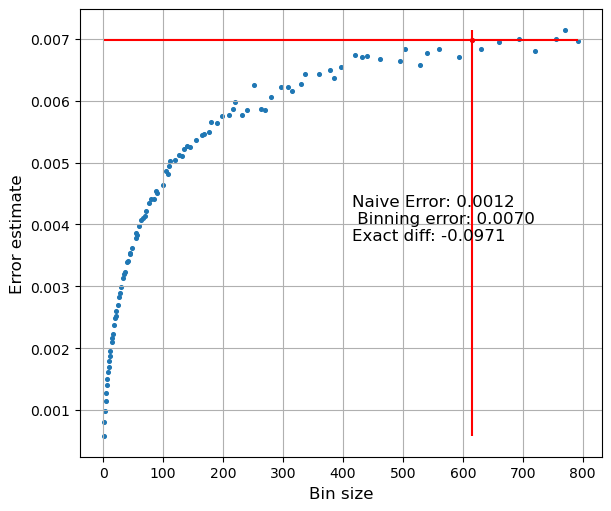

In [16]:
# TODO: Here you can do your plot of the binned errors vs bin size.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5), constrained_layout = True)
ax.scatter(bin_sizes, binned_errors, s = 7)
chosen_index = 90
diff = binned_errors[chosen_index]-exact_values[0]
ax.vlines(x = bin_sizes[chosen_index], ymin = np.min(binned_errors), ymax = np.max(binned_errors), color = "r")
ax.hlines(y=binned_errors[chosen_index], xmin=np.min(bin_sizes), xmax=np.max(bin_sizes), color="r")
ax.scatter(bin_sizes[chosen_index], binned_errors[chosen_index], color = "r", s = 7)
ax.set_xlabel("Bin size", fontsize = 12)
ax.set_ylabel("Error estimate", fontsize = 12)
ax.annotate(f"Naive Error: {naive_error:.4f}\n "f"Binning error: {binned_errors[chosen_index]:.4f}\n" f"Exact diff: {diff:.4f}", xy=(0.5 * ax.get_xlim()[1], 0.5 * ax.get_ylim()[1]), fontsize = 12)
ax.grid(True)
plt.show()

## Questions

The interaction term in the action we consider here has four fields: two at $x_{1}$ and two at $x_{2}$. \
What about terms with fewer fields?

1. Show that for an action
\begin{equation}
    S = \phi^{2}_{1} + \phi^{2}_{2} + \phi_{1} \phi_{2},
\end{equation}
we could get rid of the term $\phi_{1} \phi_{2}$ by choosing as our new variables a suitable linear combination of $\phi_{1}$ and $\phi_{2}$.

2. If $\phi_{1}$ and $\phi_{2}$ can both take values in $(-\infty, \infty)$, why are terms like $\phi^{2}_{1} \phi_{2}$ or $\phi_{1} \phi_{2}^{2}$ not allowed? \
**Hint:** What happens with $\mathrm{e}^{-S[\phi]}$?



# Answers

1. Set $\phi_1' = \frac{1}{\sqrt{2}}(\phi_1 + \phi_2)$ and $\phi_2' = \frac{1}{\sqrt{2}} (\phi_1 + \phi_2)$  
Then 
$$
    S = a\phi_1'^2 + b\phi_2'^2 , a, b \in \mathbb{R}
$$

2. The partition function would no longer be integrable. 